# Redes neuronales pre-entrenadas

En este Notebook se utilizará una red pre-entrenada de Keras para la clasificación de imágenes. Para ello, se utilizará un dataset de gatos y perros de TensorFlow como conjunto de datos. 

*Se recomienda ejecutar el Notebook en **Google Colab** y seleccionar GPU como tipo de entorno de ejecución para que las ejecuciones sean más rápidas.*

Importamos los paquetes que se utilizarán.

In [1]:
# TensorFlow
import tensorflow as tf
# Dataset
import tensorflow_datasets as tfds
# Matplotlib
import matplotlib.pyplot as plt
# NumPy
import numpy as np
# Keras
from tensorflow.keras import layers
from tensorflow.keras import models

Cargamos los datos de gatos y perros desde el paquete de datasets de TensorFlow. Utilizaremos el 50% de los datos para el entrenamiento, el 25% de los datos para la validación y 25% restante para los tests.

Esto nos devolverá un tf.data.Dataset.

In [2]:
(train_data, valid_data, test_data), info = tfds.load(
    'cats_vs_dogs', 
    split=["train[:50%]", "train[50%:75%]", "train[75%:100%]"],
    as_supervised=True,
    with_info=True,
)

Con el argumento as_supervised=True se devuelven los datos en una tupla (imagen, etiqueta) en lugar de un diccionario {'imagen': imagen, 'etiqueta': etiqueta}.

Utilizando el argumento with_info=True se obtiene la información sobre el conjunto de datos. Por ejemplo, en la información se pueden encontrar las diferentes clases y números de filas del conjunto de datos.

In [3]:
# Mostramos las clases.
class_names = info.features["label"].names
print('Clases:', class_names)

# Mostramos el número de filas.
print('Número de filas:', info.splits["train"].num_examples)

Clases: ['cat', 'dog']
Número de filas: 23262


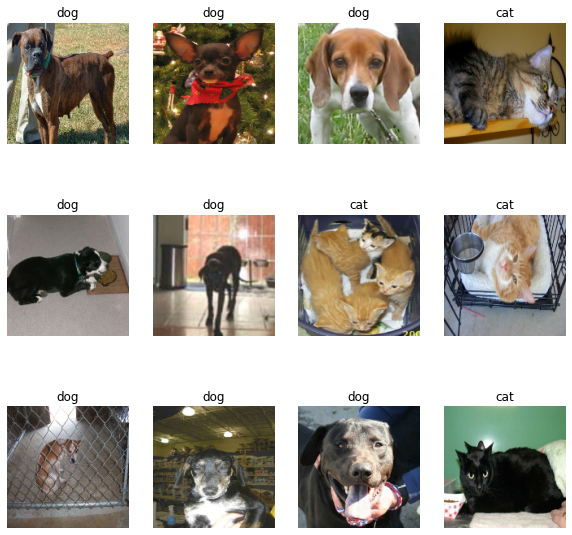

In [4]:
# Mostramos una muestra de los datos.
img_size = (150, 150)
plt.figure(figsize=(10, 10))
i = 0
for image, label in train_data.take(12):
    plt.subplot(3, 4, i + 1)
    image = tf.image.resize(image, img_size)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label])
    plt.axis("off")
    i += 1

## Preparar los datos

Podemos utilizar la API tf.data.Dataset para aplicar transformaciones al conjunto de datos antes de introducirlos en el modelo.

Nuestras imágenes tienen diferentes tamaños. Necesitamos redimensionarlas a un tamaño fijo de 150x150 píxeles. 

También aplicaremos *cache*, *shuffling*, *batching* y *prefetching* para acelerar la carga. Barajar los datos sólo es necesario para los conjuntos de entrenamiento y validación.

In [5]:
# Función para preparar el dataset.
def create_dataset(ds, batch_size=32, buffer_size=1000, shuffle=True):
    ds = ds.map(lambda x, y: (tf.image.resize(x, img_size), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache() # Cachear antes de barajar para un mayor rendimiento.
    if shuffle:
        ds = ds.shuffle(buffer_size, seed=42)
    # Poner en lotes después de barajar para obtener lotes únicos en cada época.
    ds = ds.batch(batch_size) 
    return ds.prefetch(1)

train_data = create_dataset(train_data, shuffle=True)
valid_data = create_dataset(valid_data)
test_data = create_dataset(test_data)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Si obtenemos un elemento de del objeto iterativo train_data, podemos ver las imágenes que tiene en su interior. El shape de *images* es (32, 150, 150, 3) porque el *batch_size* que hemos definido anteriormente es de 32, las imágenes son de 150x150 píxeles y son a color.

In [6]:
images, labels = next(iter(train_data))
print(images.shape)
print(labels.shape)

(32, 150, 150, 3)
(32,)


## Transferencia de aprendizaje

A la hora de cargar el modelo pre-entrenado, al utilizar weights="imagenet", le estamos diciendo a Keras que cargue el modelo con pesos entrenados en el conjunto de datos ImageNet.

El include_top=False significa que cargamos el modelo sin la "segunda parte" del modelo; el clasificador densamente conectado. Añadiremos nuestro propio clasificador como dijimos anteriormente.

Por último, utilizamos el argumento *input_shape* para especificar la forma de las imágenes que alimentaremos a la red.

In [7]:
# Cargamos el modelo pre-entrenado.
base_model = tf.keras.applications.VGG19(
        input_shape=(150, 150, 3),
        include_top=False,
        weights="imagenet",
)

Para no perder las representaciones aprendidas por la base convolucional (el modelo VGG19), es importante congelar sus capas. Congelar una capa significa que hacemos que sus pesos no sean ajustables y, por tanto, el descenso gradiente no los actualizará.

Este paso debe hacerse antes de compilar el modelo.

Para congelar todas las capas de un modelo, podemos establecer su atributo ajustable en Falso:

In [8]:
# Congelamos todas las capas del modelo pre-entrenado.
base_model.trainable = False

Ahora vamos a añadir un clasificador *fully connected (FC)* utilizando un modelo secuencial:

In [9]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(150, 150, 3)),
    layers.Rescaling(scale=1.0/255), # Los valores se reescalan a un rango entre 0 y 1.
    base_model,
    # Se añade un nuevo clasificador Fully-Connected sobre el modelo base.
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

Primero se añade una capa Rescaling para normalizar los valores al rango [0, 1], seguida de la base convolucional y, por último, añadimos un nuevo clasificador totalmente conectado.

Nótese que estamos utilizando una capa Densa con un nodo como salida. Y puesto que estamos tratando con un problema binario, utilizamos la función de activación sigmoide.

Ahora que la base convolucional está congelada, podemos compilar y empezar el entrenamiento:

In [10]:
# Compilamos el modelo y empezamos con el entrenamiento.
learning_rate = 1e-4
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              metrics=['acc']
             )

epochs = 10
history = model.fit(train_data, epochs=epochs,
                   validation_data=valid_data)

Epoch 1/10
364/364 [==============================] - 68s 152ms/step - loss: 0.3631 - acc: 0.8333 - val_loss: 0.4652 - val_acc: 0.7785
Epoch 2/10
364/364 [==============================] - 46s 127ms/step - loss: 0.2608 - acc: 0.8907 - val_loss: 0.4592 - val_acc: 0.8046
Epoch 3/10
364/364 [==============================] - 48s 132ms/step - loss: 0.2277 - acc: 0.9032 - val_loss: 0.2322 - val_acc: 0.9020
Epoch 4/10
364/364 [==============================] - 51s 141ms/step - loss: 0.2044 - acc: 0.9137 - val_loss: 0.2357 - val_acc: 0.9016
Epoch 5/10
364/364 [==============================] - 47s 130ms/step - loss: 0.1852 - acc: 0.9224 - val_loss: 0.2322 - val_acc: 0.9015
Epoch 6/10
364/364 [==============================] - 46s 127ms/step - loss: 0.1692 - acc: 0.9312 - val_loss: 0.4888 - val_acc: 0.8033
Epoch 7/10
364/364 [==============================] - 52s 143ms/step - loss: 0.1515 - acc: 0.9380 - val_loss: 0.2609 - val_acc: 0.8894
Epoch 8/10
364/364 [==============================] - 5

Como sólo hay dos clases, gatos y perros, utilizamos la función de pérdida *"binary_crossentropy"*.

Ahora ploteamos las curvas de aprendizaje del modelo:

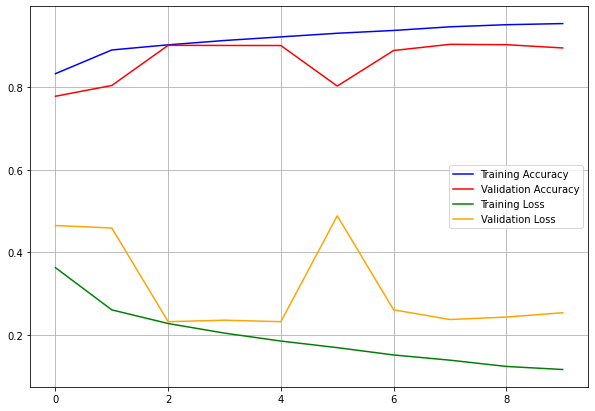

In [11]:
def plot_learning_curves():
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 7))
    plt.plot(range(epochs), acc, "b", label="Training Accuracy")
    plt.plot(range(epochs), val_acc, "r", label="Validation Accuracy")
    plt.legend()

    plt.plot(range(epochs), loss, "g", label="Training Loss")
    plt.plot(range(epochs), val_loss, "orange", label="Validation Loss")
    plt.legend()
    plt.grid(True)

    plt.show()

plot_learning_curves()

En la curva de aprendizaje, podemos ver que quizás haya un poco de sobreajuste, pero en general los resultados obtenidos son bastante buenos.

## Fine tuning

Ahora lo que podemos hacer para intentar mejorar aún más la precisión del modelo es utilizar el fine tuning. Esto consiste en descongelar las capas superiores de la base convolucional y volver a entrenar la red con una tasa de aprendizaje baja.

Es importante intentar el fine tuning sólo después de entrenar el clasificador densamente conectado que se ha añadido encima de la base convolucional porque, de lo contrario, las actualizaciones de los pesos serán demasiado grandes y esto destruirá las características aprendidas por las capas que se están ajustando.

In [12]:
# Descongelamos las capas del modelo pre-entrenado.
base_model.trainable = True

In [13]:
# Congelamos todas las capas menos las últimas 10.
for layer in base_model.layers[:-10]: 
    layer.trainable = False

# Compilamos y reentrenamos con un bajo ratio de aprendizaje para que no modifique en exceso los pesos del modelo pre-entrenado.
low_lr = learning_rate / 10
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=low_lr), 
              metrics=['acc']
)

epochs = 10
history = model.fit(train_data, epochs=epochs,
                    validation_data=valid_data)

Epoch 1/10
364/364 [==============================] - 79s 205ms/step - loss: 0.1110 - acc: 0.9558 - val_loss: 0.1871 - val_acc: 0.9261
Epoch 2/10
364/364 [==============================] - 74s 203ms/step - loss: 0.0402 - acc: 0.9856 - val_loss: 0.1930 - val_acc: 0.9384
Epoch 3/10
364/364 [==============================] - 68s 186ms/step - loss: 0.0197 - acc: 0.9929 - val_loss: 0.2573 - val_acc: 0.9302
Epoch 4/10
364/364 [==============================] - 68s 187ms/step - loss: 0.0109 - acc: 0.9968 - val_loss: 0.2358 - val_acc: 0.9441
Epoch 5/10
364/364 [==============================] - 68s 186ms/step - loss: 0.0071 - acc: 0.9979 - val_loss: 0.2417 - val_acc: 0.9484
Epoch 6/10
364/364 [==============================] - 67s 185ms/step - loss: 0.0076 - acc: 0.9977 - val_loss: 0.2699 - val_acc: 0.9484
Epoch 7/10
364/364 [==============================] - 67s 185ms/step - loss: 0.0025 - acc: 0.9992 - val_loss: 0.2668 - val_acc: 0.9469
Epoch 8/10
364/364 [==============================] - 6

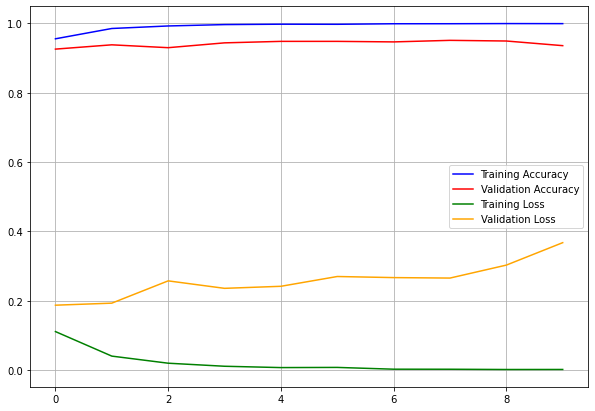

In [14]:
plot_learning_curves()

Parece que se ha conseguido mejorar el modelo, pero aunque no parezca importante, todavía hay un pequeño sobreajuste. 

## Evaluación de la red neuronal

In [15]:
test_loss, test_acc = model.evaluate(test_data)
print(np.round(test_acc * 100, 2), '%')

182/182 [==============================] - 18s 93ms/step - loss: 0.3464 - acc: 0.9383
93.83 %


Utilicemos el modelo para hacer algunas predicciones sobre un lote de imágenes:

In [16]:
image_batch, label_batch = next(iter(test_data))
proba = model.predict(image_batch)
# Devuelve 0 en el caso de que la probabilidad de predicción sea menor que 0.5, en caso contrario devuelve un 1.
y_preds = tf.where(proba < 0.5, 0, 1)

1/1 [==============================] - 0s 394ms/step


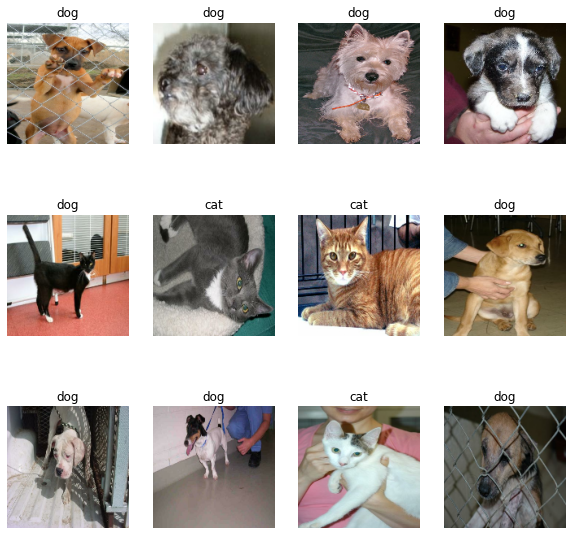

In [17]:
def show_prediction(image, y_pred):
    plt.imshow(image / 255)
    plt.title(class_names[y_pred.numpy()[0]])
    plt.axis("off")

plt.figure(figsize=(10, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    show_prediction(image_batch[i], y_preds[i])